In [1]:
import xarray as xr
import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib import ticker
from metpy.calc import vertical_velocity
from metpy.units import units
import cmaps

from toolbar.TN_WaveActivityFlux import TN_WAF_3D
from toolbar.curved_quivers.modplot import *
from toolbar.data_read import *
from toolbar.lonlat_transform import *


def regress(time_series, data):
    # 将 data 重塑为二维：时间轴为第一个维度
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以中心化（标准化自变量和因变量）
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差的分子）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（自变量的平方和）
    denominator = np.sum(time_series_mean ** 2)

    # 计算回归系数
    regression_coef = numerator / denominator
    correlation = numerator / (np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2)))
    # 重塑为 (lat, lon)
    regression_map = regression_coef.reshape(data.shape[1:])
    correlation_map = correlation.reshape(data.shape[1:])
    return regression_map, correlation_map


K_type = xr.open_dataset(r"D:/PyFile/p2/data/Time_type_AverFiltAll0.9%_0.3%_3.nc")
Z = xr.open_dataset(r"D:/PyFile/p2/data/Z.nc").sel(level=[100, 150, 200, 300, 400, 500, 600, 700, 850, 900, 1000], lat=slice(5, -5), lon=slice(0, 360)) / 9.8
U = xr.open_dataset(r"D:/PyFile/p2/data/U.nc").sel(level=[100, 150, 200, 300, 400, 500, 600, 700, 850, 900, 1000], lat=slice(5, -5), lon=slice(0, 360))
T = xr.open_dataset(r"D:/PyFile/p2/data/T.nc").sel(level=[100, 150, 200, 300, 400, 500, 600, 700, 850, 900, 1000], lat=slice(5, -5), lon=slice(0, 360))
W = xr.open_dataset(r"D:/PyFile/p2/data/W.nc").sel(level=[100, 150, 200, 300, 400, 500, 600, 700, 850, 900, 1000], lat=slice(5, -5), lon=slice(0, 360))
W = vertical_velocity(W['w'] * units('Pa/s') , W['level'] * units.hPa, T['t'] * units.degC)
Pre = xr.open_dataset(r"D:/PyFile/p2/data/pre.nc").sel(lat=slice(5, -5), lon=slice(0, 360))
Sst = xr.open_dataset(r"D:/PyFile/p2/data/sst.nc").sel(lat=slice(5, -5), lon=slice(0, 360))
Terrain = xr.open_dataset(r"E:\data\NOAA\ETOPO\ETOPO_2022_v1_30s_N90W180_bed.nc").sel(lat=slice(-5, 5), lon=slice(-180, 180))['z'].astype(np.float64).mean(dim='lat', skipna=True)
Z = transform(Z['z'], lon_name='lon', type='180->360')
U = transform(U['u'], lon_name='lon', type='180->360')
W = transform(W, lon_name='lon', type='180->360')
Pre = transform(Pre['pre'], lon_name='lon', type='180->360')
Sst = transform(Sst['sst'], lon_name='lon', type='180->360')
Terrain = transform(Terrain, lon_name='lon', type='180->360')

Terrain_ver = np.array(Terrain)
Terrain_ver = 1013 * (1 - 6.5/288000 * Terrain_ver)**5.255
lon_Terrain = Terrain.lon

路径积分: 100%|██████████| 322/322 [00:05<00:00, 58.54points/s] 


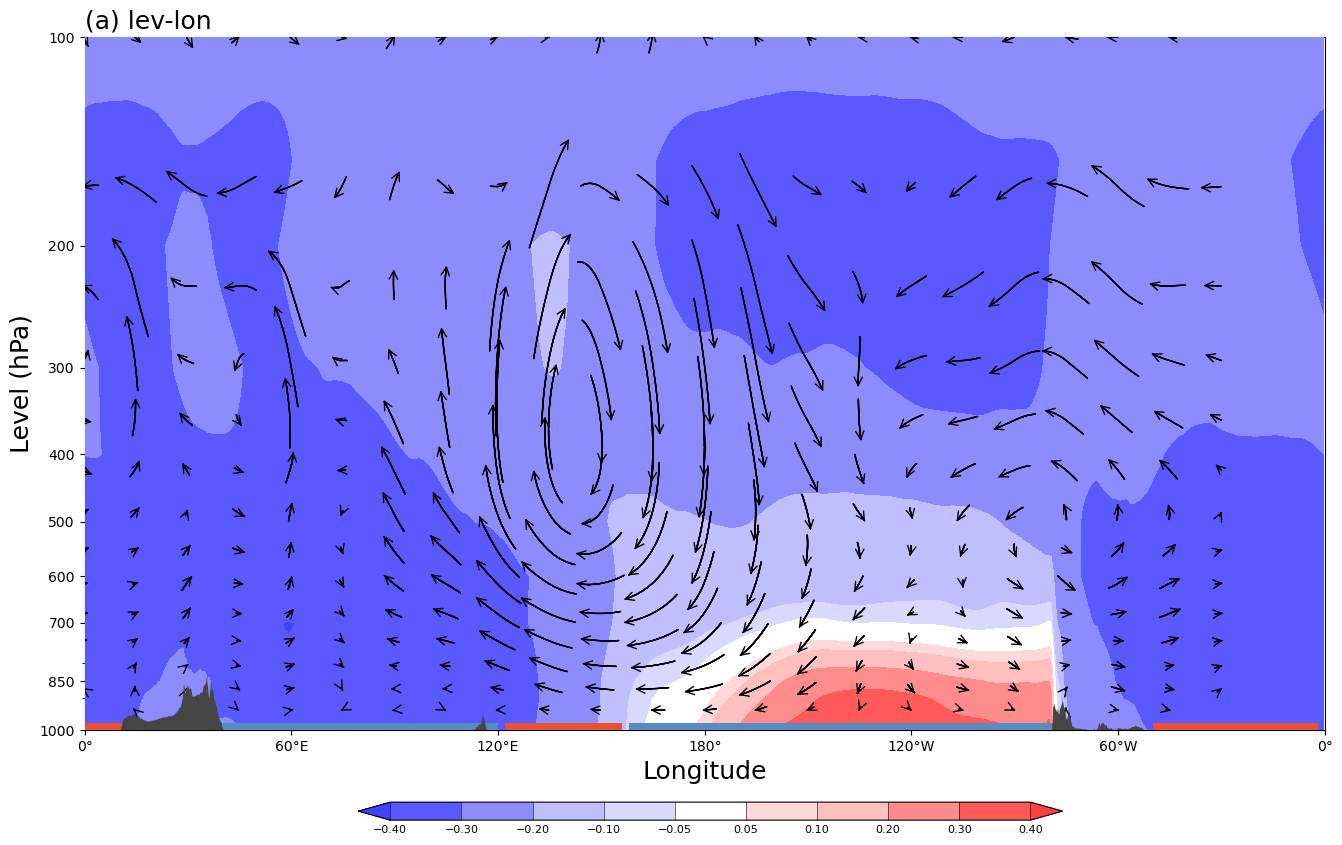

路径积分: 100%|██████████| 322/322 [00:03<00:00, 88.15points/s] 


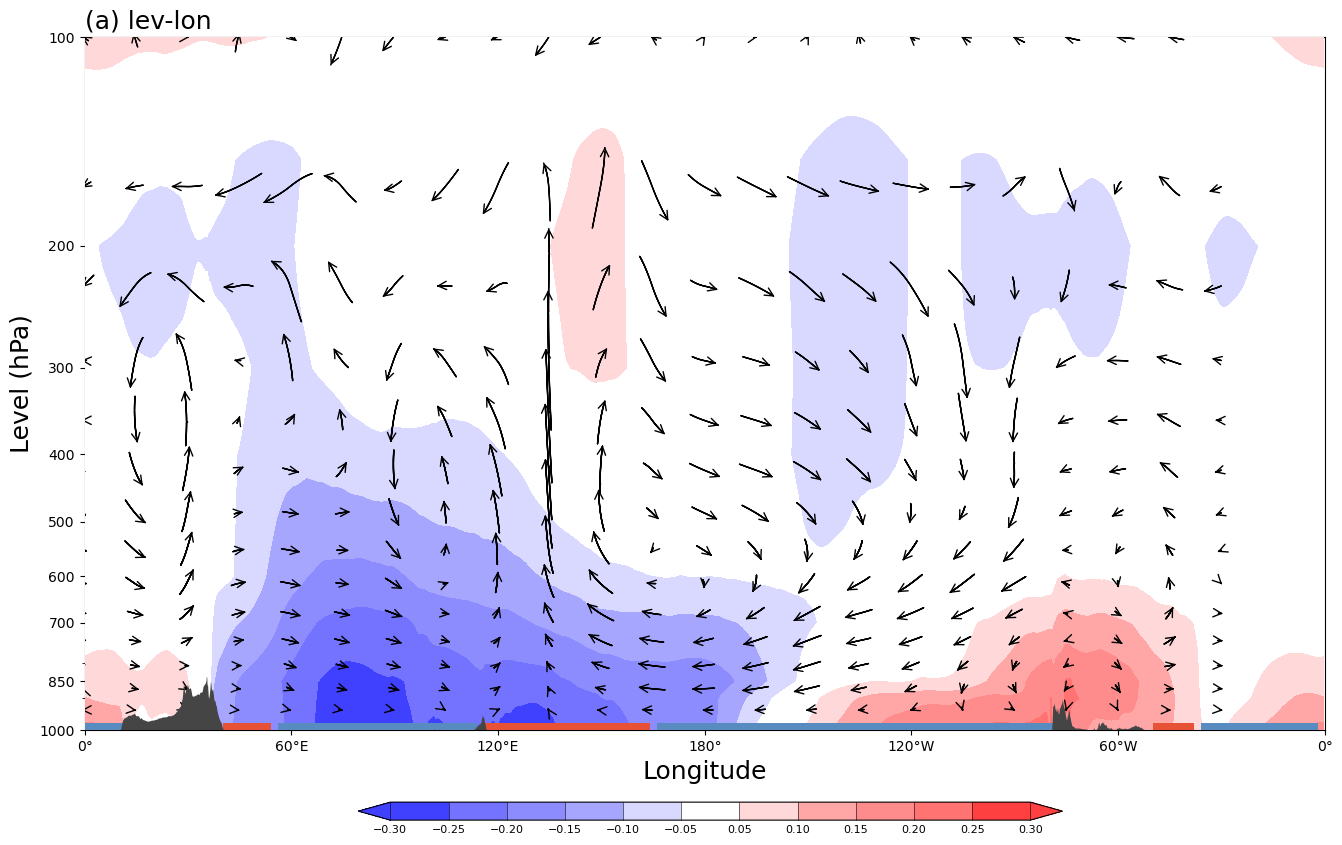

路径积分: 100%|██████████| 322/322 [00:05<00:00, 54.62points/s]


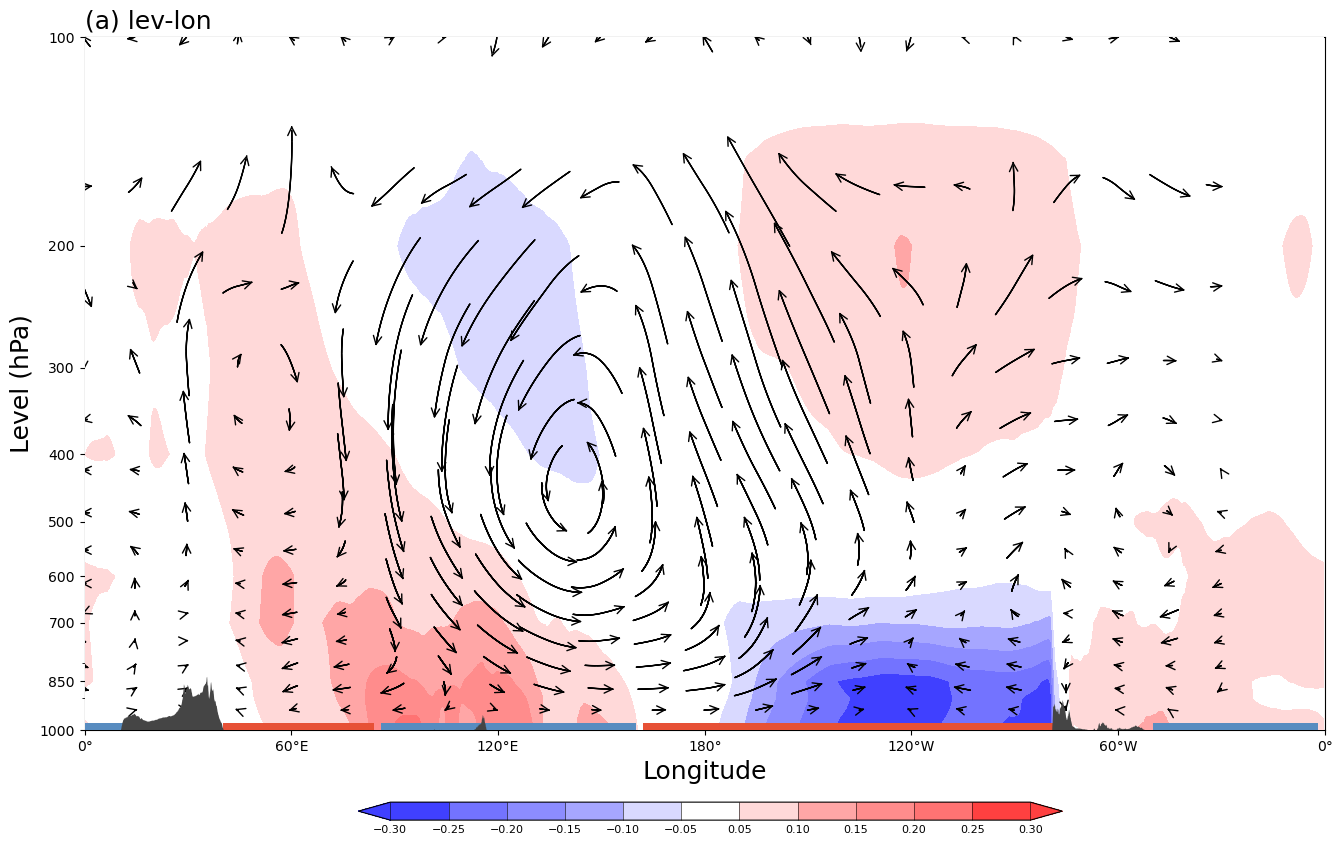

In [4]:
for i in range(len(K_type['type'])):
    fig = plt.figure(figsize=(16, 9))
    K = K_type['K'].sel(type=i+1).data
    if i == 1: K = K - np.polyval(np.polyfit(range(len(K)), K, 1), range(len(K)))  # 去除全域一致型的趋势
    K = (K - np.mean(K)) / np.var(K)
    Z_reg, Z_cor = regress(K, Z.data)
    Z_nc = xr.Dataset({'reg': (['level', 'lat', 'lon'], Z_reg),
                        'corr': (['level', 'lat', 'lon'], Z_cor)},
                      coords={'level': Z['level'], 'lat': Z['lat'], 'lon': Z['lon']})
    del Z_reg, Z_cor
    U_reg, U_cor = regress(K, U.data)
    U_nc = xr.Dataset({'reg': (['level', 'lat', 'lon'], U_reg),
                       'corr': (['level', 'lat', 'lon'], U_cor)},
                      coords={'level': U['level'], 'lat': U['lat'], 'lon': U['lon']})
    del U_reg, U_cor
    W_reg, W_cor = regress(K, W.data)
    W_nc = xr.Dataset({'reg': (['level', 'lat', 'lon'], W_reg),
                       'corr': (['level', 'lat', 'lon'], W_cor)},
                      coords={'level': W['level'], 'lat': W['lat'], 'lon': W['lon']})
    del W_reg, W_cor
    Pre_reg, Pre_cor = regress(K, Pre.data)
    Pre_nc = xr.Dataset({'reg': (['lat', 'lon'], Pre_reg),
                         'corr': (['lat', 'lon'], Pre_cor)},
                        coords={'lat': Pre['lat'], 'lon': Pre['lon']})
    del Pre_reg, Pre_cor
    Sst_reg, Sst_cor = regress(K, Sst.data)
    Sst_nc = xr.Dataset({'reg': (['lat', 'lon'], Sst_reg),
                         'corr': (['lat', 'lon'], Sst_cor)},
                        coords={'lat': Sst['lat'], 'lon': Sst['lon']})
    del Sst_reg, Sst_cor
    W_nc['reg'] *= 2 * np.pi * 6.371e6 * np.cos(np.nanmean(Z_nc['lat'])) / 16000  # 图片投影换算

    f_ax = fig.add_subplot(111)
    f_ax.set_title('(a) lev-lon', loc='left', fontsize=18)
    f_ax.set_ylabel('Level (hPa)', fontsize=18)
    f_ax.set_xlabel('Longitude', fontsize=18)
    f_ax.set_xlim(0, 360)
    f_ax.set_ylim(1000, 100)

    f_ax.fill_between(lon_Terrain, Terrain_ver, 1010, where=Terrain_ver < 1010, facecolor='#454545', zorder=10) # 地形
    f_ax.fill_between(Sst_nc['lon'], 1000, 975, where=Sst_nc['reg'].mean('lat', skipna=True) > 0, facecolor='#E75136', zorder=9) # 暖海温异常
    f_ax.fill_between(Sst_nc['lon'], 1000, 975, where=Sst_nc['reg'].mean('lat', skipna=True) < 0, facecolor='#588CC0', zorder=9) # 冷海温异常
    vec = Curlyquiver(f_ax, U_nc['lon'], U_nc['level'], U_nc['reg'].mean('lat'), -W_nc['reg'].mean('lat'), arrowsize=1.5, scale=10, linewidth=1, regrid=[25, 15], color='k', zorder=9)
    if i == 0: lev_z = np.array([-.4, -.3, -.2, -.1, -.05, .05, .1, .2, .3, .4])
    else: lev_z = np.array([-.3, -.25, -.2, -.15, -.1, -.05, .05, .1, .15, .2, .25, .3])
    z = f_ax.contourf(Z_nc['lon'], Z_nc['level'], Z_nc['corr'].mean('lat', skipna=True), levels=lev_z, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], zorder=8, extend='both')

    # color bar位置
    position = fig.add_axes([0.296, 0.01, 0.44, 0.02])
    cb1 = plt.colorbar(z, cax=position, orientation='horizontal', drawedges=True)#orientation为水平或垂直
    cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb1.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb1.ax.tick_params(length=0, labelsize=8)#length为刻度线的长度
    cb1.locator = ticker.FixedLocator(lev_z) # colorbar上的刻度值个数

    f_ax.set_xticks([0, 60, 120, 180, 240, 300, 360])
    f_ax.set_xticklabels(['0°', '60°E', '120°E', '180°', '120°W', '60°W', '0°'])
    f_ax.set_yscale('log')
    f_ax.set_yticks([1000, 850, 700, 600, 500, 400, 300, 200, 100])
    f_ax.set_yticklabels(['1000','850', '700', '600', '500', '400', '300', '200', '100'])

    plt.savefig(fr'D:/PyFile/p2/pic/赤道纬向环流{i}.pdf', dpi=300, bbox_inches='tight')
    plt.show()